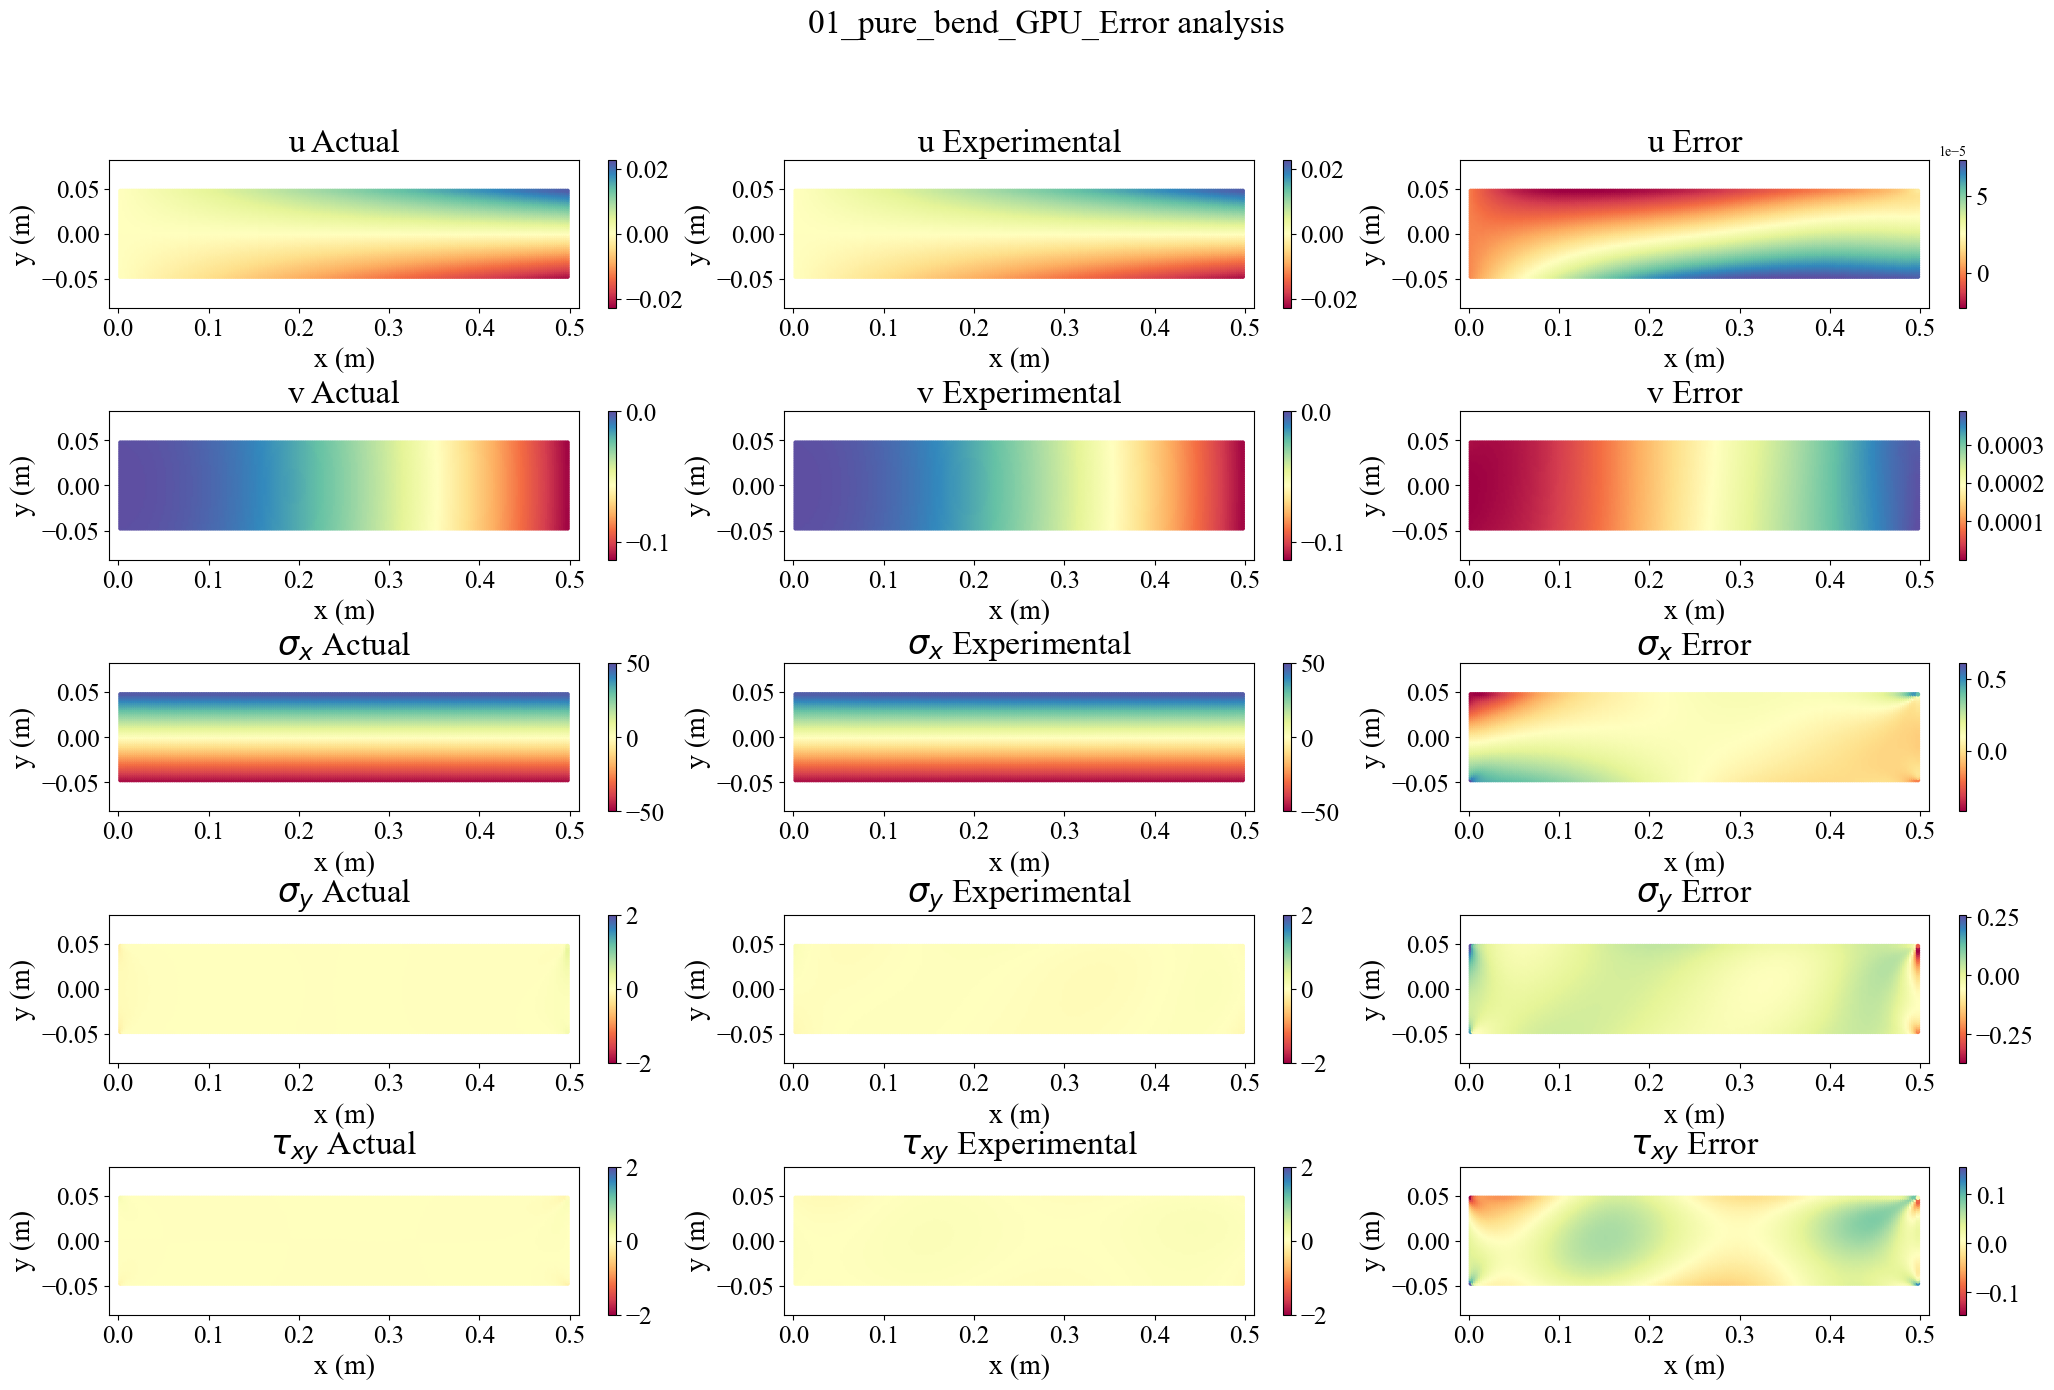

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from scipy.spatial import cKDTree

# 设置字体为新罗马字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# 定义坐标边界
xmin, xmax = -0.01, 0.51
ymin, ymax = -0.06, 0.06

# 保存图像的路径
save_path = '../Error analysis/'
displacement_file = '../FEM/displacement_data.csv'
stress_file = '../FEM/stress_data.csv'
mat_file = '../GPU/out.mat'

# 读取CSV文件
displacement_data = pd.read_csv(displacement_file)
stress_data = pd.read_csv(stress_file)

# 读取MAT文件
mat_data = scipy.io.loadmat(mat_file)

# 获取基准数据
ref_coords = displacement_data[['X', 'Y']].values
u_ref = displacement_data['Disp_x'].values
v_ref = displacement_data['Disp_y'].values
sigma_x_ref = stress_data['Sigma_x'].values
sigma_y_ref = stress_data['Sigma_y'].values
tau_xy_ref = stress_data['Tau_xy'].values

# 获取计算结果
calc_coords = mat_data['xy']
u = mat_data['u'][:, 0]
v = mat_data['u'][:, 1]
sigma_x = mat_data['s11'].flatten()
sigma_y = mat_data['s22'].flatten()
tau_xy = mat_data['s12'].flatten()

# 使用KDTree匹配坐标
tree = cKDTree(ref_coords)
_, indices = tree.query(calc_coords)

u_ref_matched = u_ref[indices]
v_ref_matched = v_ref[indices]
sigma_x_ref_matched = sigma_x_ref[indices]
sigma_y_ref_matched = sigma_y_ref[indices]
tau_xy_ref_matched = tau_xy_ref[indices]

# 计算误差
u_error = u - u_ref_matched
v_error = v - v_ref_matched
sigma_x_error = sigma_x - sigma_x_ref_matched
sigma_y_error = sigma_y - sigma_y_ref_matched
tau_xy_error = tau_xy - tau_xy_ref_matched

# 过滤有效点
vxmin, vxmax = 0, 0.5
vymin, vymax = -0.05, 0.05
valid_points = (calc_coords[:, 0] > vxmin) & (calc_coords[:, 0] < vxmax) & (calc_coords[:, 1] > vymin) & (calc_coords[:, 1] < vymax)

calc_coords = calc_coords[valid_points]
u = u[valid_points]
v = v[valid_points]
sigma_x = sigma_x[valid_points]
sigma_y = sigma_y[valid_points]
tau_xy = tau_xy[valid_points]

u_error = u_error[valid_points]
v_error = v_error[valid_points]
sigma_x_error = sigma_x_error[valid_points]
sigma_y_error = sigma_y_error[valid_points]
tau_xy_error = tau_xy_error[valid_points]

u_ref_matched = u_ref_matched[valid_points]
v_ref_matched = v_ref_matched[valid_points]
sigma_x_ref_matched = sigma_x_ref_matched[valid_points]
sigma_y_ref_matched = sigma_y_ref_matched[valid_points]
tau_xy_ref_matched = tau_xy_ref_matched[valid_points]

# 保存误差到MAT文件
scipy.io.savemat(save_path + 'LLL_GPU.mat', {
    'xy': calc_coords,
    'u_error': u_error,
    'v_error': v_error,
    'sigma_x_error': sigma_x_error,
    'sigma_y_error': sigma_y_error,
    'tau_xy_error': tau_xy_error
})

# 设置颜色映射的上下限
limits = {
    'u': (-0.0228, 0.0228),
    'v': (-0.1138, 0),
    'sigma_x': (-50, 50),
    'sigma_y': (-2, 2),
    'tau_xy': (-2, 2)
}

# 数据和标签
data = {
    'u': u,
    'v': v,
    'sigma_x': sigma_x,
    'sigma_y': sigma_y,
    'tau_xy': tau_xy
}

ref_data = {
    'u': u_ref_matched,
    'v': v_ref_matched,
    'sigma_x': sigma_x_ref_matched,
    'sigma_y': sigma_y_ref_matched,
    'tau_xy': tau_xy_ref_matched
}

errors = {
    'u': u_error,
    'v': v_error,
    'sigma_x': sigma_x_error,
    'sigma_y': sigma_y_error,
    'tau_xy': tau_xy_error
}

titles = {
    'u': 'u',
    'v': 'v',
    'sigma_x': r'$\sigma_{x}$',
    'sigma_y': r'$\sigma_{y}$',
    'tau_xy': r'$\tau_{xy}$'
}

# 设置字体大小
title_fontsize = 24
label_fontsize = 20
colorbar_fontsize = 18
tick_fontsize = 18  # 坐标轴字体大小

# 绘制实验值、实际值和误差图
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(25, 15))
fig.subplots_adjust(hspace=0.7, wspace=0.15)
fig.suptitle("01_pure_bend_GPU_Error analysis", fontsize=24)  # 增加大标题

for i, key in enumerate(data.keys()):
    # 绘制实验值图
    cf = ax[i, 1].scatter(calc_coords[:, 0], calc_coords[:, 1], s=5, c=data[key], cmap='Spectral', vmin=limits[key][0], vmax=limits[key][1])
    ax[i, 1].axis('equal')
    cbar = plt.colorbar(cf, ax=ax[i, 0])
    cbar.ax.tick_params(labelsize=colorbar_fontsize)
    ax[i, 1].set_xlim([xmin, xmax])
    ax[i, 1].set_ylim([ymin, ymax])
    ax[i, 1].set_title(f'{titles[key]} Experimental', fontsize=title_fontsize)
    ax[i, 1].set_xlabel('x (m)', fontsize=label_fontsize)
    ax[i, 1].set_ylabel('y (m)', fontsize=label_fontsize)
    ax[i, 1].tick_params(axis='both', labelsize=tick_fontsize)  # 调整坐标轴字体大小

    # 绘制实际值图
    cf = ax[i, 0].scatter(calc_coords[:, 0], calc_coords[:, 1], s=5, c=ref_data[key], cmap='Spectral', vmin=limits[key][0], vmax=limits[key][1])
    ax[i, 0].axis('equal')
    cbar = plt.colorbar(cf, ax=ax[i, 1])
    cbar.ax.tick_params(labelsize=colorbar_fontsize)
    ax[i, 0].set_xlim([xmin, xmax])
    ax[i, 0].set_ylim([ymin, ymax])
    ax[i, 0].set_title(f'{titles[key]} Actual', fontsize=title_fontsize)
    ax[i, 0].set_xlabel('x (m)', fontsize=label_fontsize)
    ax[i, 0].set_ylabel('y (m)', fontsize=label_fontsize)
    ax[i, 0].tick_params(axis='both', labelsize=tick_fontsize)  # 调整坐标轴字体大小

    # 绘制误差图
    cf = ax[i, 2].scatter(calc_coords[:, 0], calc_coords[:, 1], s=5, c=errors[key], cmap='Spectral')
    ax[i, 2].axis('equal')
    cbar = plt.colorbar(cf, ax=ax[i, 2])
    cbar.ax.tick_params(labelsize=colorbar_fontsize)
    ax[i, 2].set_xlim([xmin, xmax])
    ax[i, 2].set_ylim([ymin, ymax])
    ax[i, 2].set_title(f'{titles[key]} Error', fontsize=title_fontsize)
    ax[i, 2].set_xlabel('x (m)', fontsize=label_fontsize)
    ax[i, 2].set_ylabel('y (m)', fontsize=label_fontsize)
    ax[i, 2].tick_params(axis='both', labelsize=tick_fontsize)  # 调整坐标轴字体大小

fig.savefig(save_path + "Error_GPU.png", dpi=600)
plt.show()


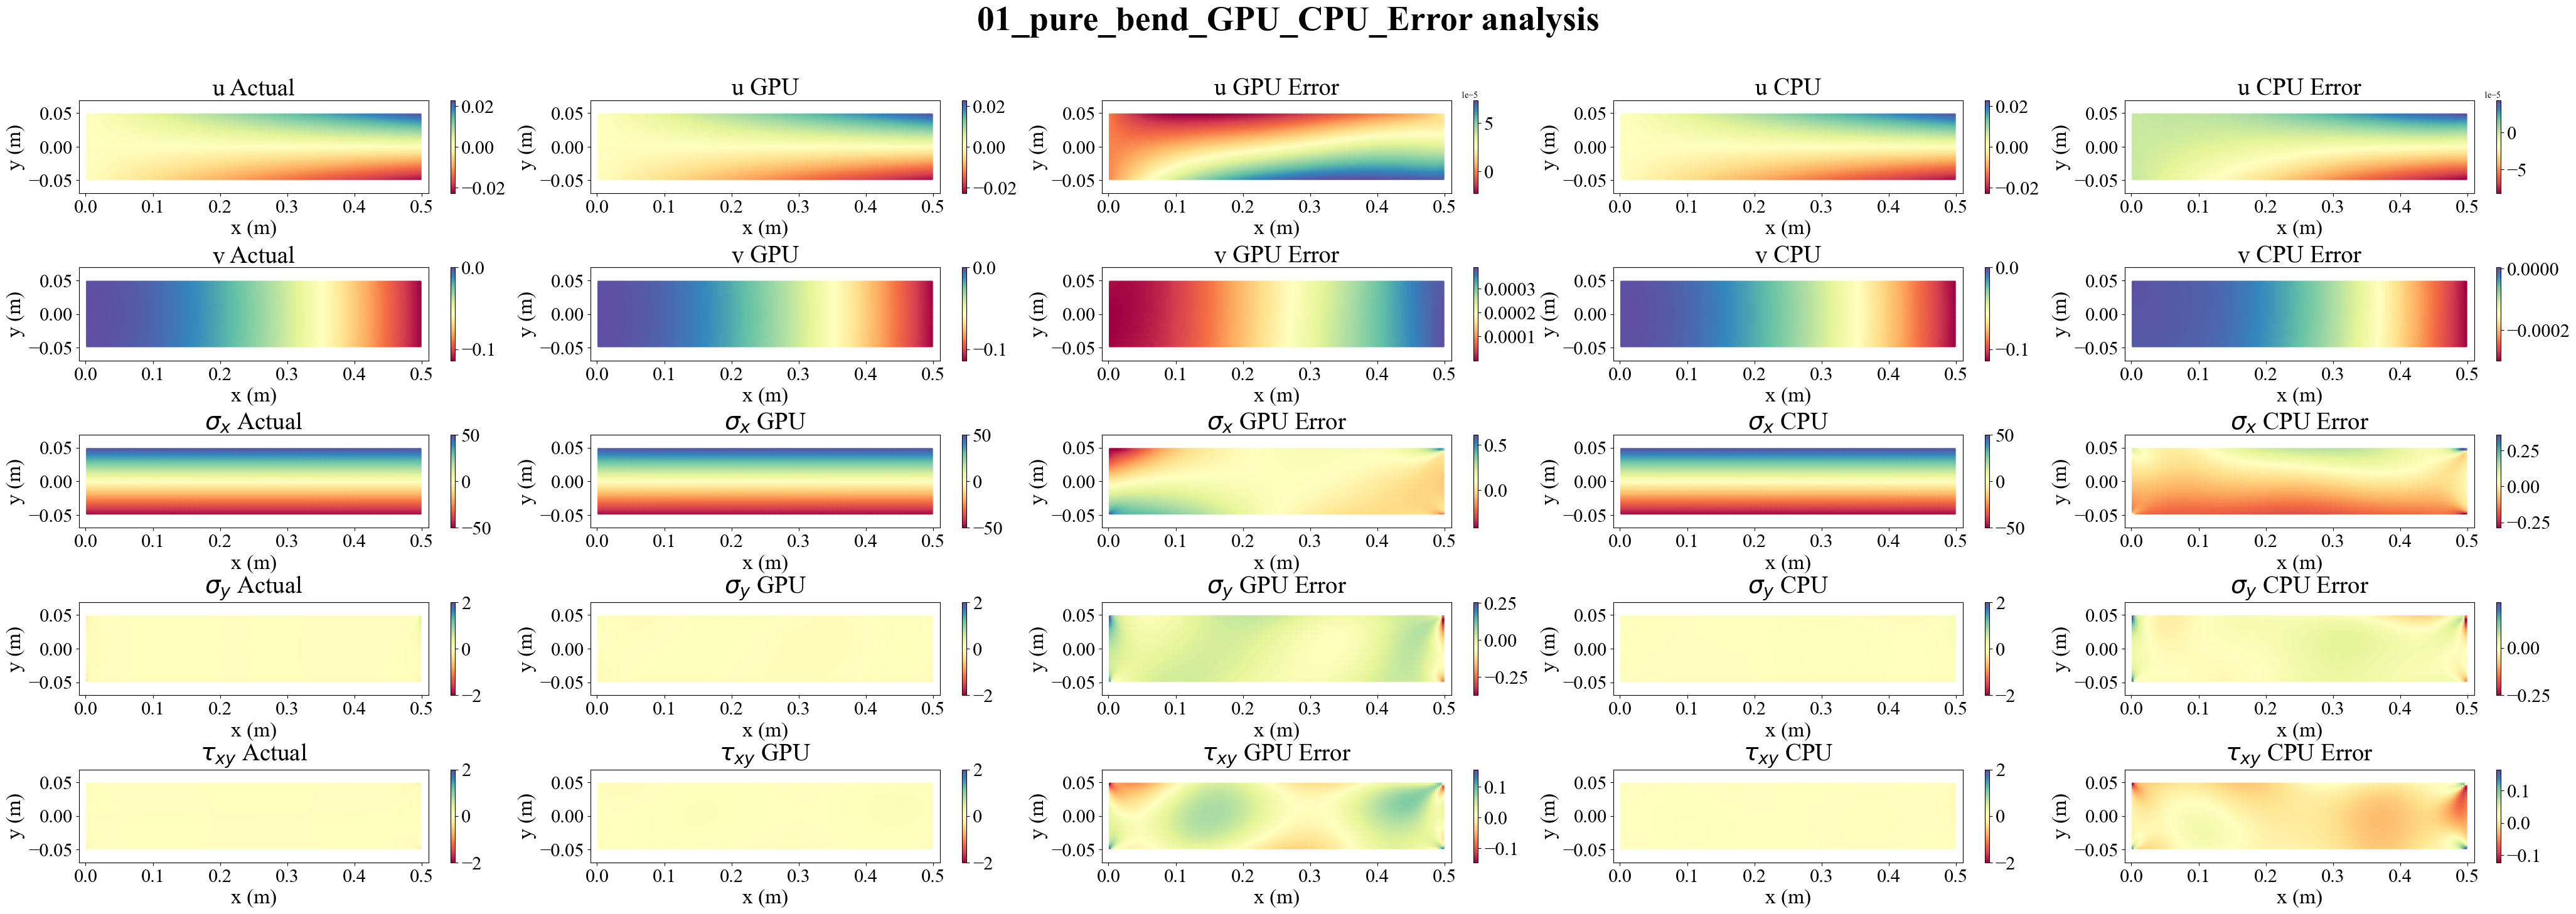

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from scipy.spatial import cKDTree

# 设置字体为新罗马字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# 定义坐标边界
xmin, xmax = -0.01, 0.51
ymin, ymax = -0.06, 0.06

# 保存图像的路径
save_path = '../Error analysis/'
displacement_file = '../FEM/displacement_data.csv'
stress_file = '../FEM/stress_data.csv'
gpu_mat_file = '../GPU/out.mat'
cpu_mat_file = '../CPU/out.mat'

# 读取CSV文件
displacement_data = pd.read_csv(displacement_file)
stress_data = pd.read_csv(stress_file)

# 读取GPU MAT文件
gpu_mat_data = scipy.io.loadmat(gpu_mat_file)

# 读取CPU MAT文件
cpu_mat_data = scipy.io.loadmat(cpu_mat_file)

# 获取基准数据
ref_coords = displacement_data[['X', 'Y']].values
u_ref = displacement_data['Disp_x'].values
v_ref = displacement_data['Disp_y'].values
sigma_x_ref = stress_data['Sigma_x'].values
sigma_y_ref = stress_data['Sigma_y'].values
tau_xy_ref = stress_data['Tau_xy'].values

# 获取GPU计算结果
gpu_coords = gpu_mat_data['xy']
gpu_u = gpu_mat_data['u'][:, 0]
gpu_v = gpu_mat_data['u'][:, 1]
gpu_sigma_x = gpu_mat_data['s11'].flatten()
gpu_sigma_y = gpu_mat_data['s22'].flatten()
gpu_tau_xy = gpu_mat_data['s12'].flatten()

# 获取CPU计算结果
cpu_coords = cpu_mat_data['xy']
cpu_u = cpu_mat_data['u'][:, 0]
cpu_v = cpu_mat_data['u'][:, 1]
cpu_sigma_x = cpu_mat_data['s11'].flatten()
cpu_sigma_y = cpu_mat_data['s22'].flatten()
cpu_tau_xy = cpu_mat_data['s12'].flatten()

# 使用KDTree匹配坐标
tree = cKDTree(ref_coords)
_, gpu_indices = tree.query(gpu_coords)
_, cpu_indices = tree.query(cpu_coords)

gpu_u_ref_matched = u_ref[gpu_indices]
gpu_v_ref_matched = v_ref[gpu_indices]
gpu_sigma_x_ref_matched = sigma_x_ref[gpu_indices]
gpu_sigma_y_ref_matched = sigma_y_ref[gpu_indices]
gpu_tau_xy_ref_matched = tau_xy_ref[gpu_indices]

cpu_u_ref_matched = u_ref[cpu_indices]
cpu_v_ref_matched = v_ref[cpu_indices]
cpu_sigma_x_ref_matched = sigma_x_ref[cpu_indices]
cpu_sigma_y_ref_matched = sigma_y_ref[cpu_indices]
cpu_tau_xy_ref_matched = tau_xy_ref[cpu_indices]

# 计算GPU误差
gpu_u_error = gpu_u - gpu_u_ref_matched
gpu_v_error = gpu_v - gpu_v_ref_matched
gpu_sigma_x_error = gpu_sigma_x - gpu_sigma_x_ref_matched
gpu_sigma_y_error = gpu_sigma_y - gpu_sigma_y_ref_matched
gpu_tau_xy_error = gpu_tau_xy - gpu_tau_xy_ref_matched

# 计算CPU误差
cpu_u_error = cpu_u - cpu_u_ref_matched
cpu_v_error = cpu_v - cpu_v_ref_matched
cpu_sigma_x_error = cpu_sigma_x - cpu_sigma_x_ref_matched
cpu_sigma_y_error = cpu_sigma_y - cpu_sigma_y_ref_matched
cpu_tau_xy_error = cpu_tau_xy - cpu_tau_xy_ref_matched

# 过滤有效点
vxmin, vxmax = 0, 0.5
vymin, vymax = -0.05, 0.05
valid_points = (gpu_coords[:, 0] > vxmin) & (gpu_coords[:, 0] < vxmax) & (gpu_coords[:, 1] > vymin) & (gpu_coords[:, 1] < vymax)

gpu_coords = gpu_coords[valid_points]
gpu_u = gpu_u[valid_points]
gpu_v = gpu_v[valid_points]
gpu_sigma_x = gpu_sigma_x[valid_points]
gpu_sigma_y = gpu_sigma_y[valid_points]
gpu_tau_xy = gpu_tau_xy[valid_points]

gpu_u_error = gpu_u_error[valid_points]
gpu_v_error = gpu_v_error[valid_points]
gpu_sigma_x_error = gpu_sigma_x_error[valid_points]
gpu_sigma_y_error = gpu_sigma_y_error[valid_points]
gpu_tau_xy_error = gpu_tau_xy_error[valid_points]

gpu_u_ref_matched = gpu_u_ref_matched[valid_points]
gpu_v_ref_matched = gpu_v_ref_matched[valid_points]
gpu_sigma_x_ref_matched = gpu_sigma_x_ref_matched[valid_points]
gpu_sigma_y_ref_matched = gpu_sigma_y_ref_matched[valid_points]
gpu_tau_xy_ref_matched = gpu_tau_xy_ref_matched[valid_points]

valid_points_cpu = (cpu_coords[:, 0] > vxmin) & (cpu_coords[:, 0] < vxmax) & (cpu_coords[:, 1] > vymin) & (cpu_coords[:, 1] < vymax)

cpu_coords = cpu_coords[valid_points_cpu]
cpu_u = cpu_u[valid_points_cpu]
cpu_v = cpu_v[valid_points_cpu]
cpu_sigma_x = cpu_sigma_x[valid_points_cpu]
cpu_sigma_y = cpu_sigma_y[valid_points_cpu]
cpu_tau_xy = cpu_tau_xy[valid_points_cpu]

cpu_u_error = cpu_u_error[valid_points_cpu]
cpu_v_error = cpu_v_error[valid_points_cpu]
cpu_sigma_x_error = cpu_sigma_x_error[valid_points_cpu]
cpu_sigma_y_error = cpu_sigma_y_error[valid_points_cpu]
cpu_tau_xy_error = cpu_tau_xy_error[valid_points_cpu]

cpu_u_ref_matched = cpu_u_ref_matched[valid_points_cpu]
cpu_v_ref_matched = cpu_v_ref_matched[valid_points_cpu]
cpu_sigma_x_ref_matched = cpu_sigma_x_ref_matched[valid_points_cpu]
cpu_sigma_y_ref_matched = cpu_sigma_y_ref_matched[valid_points_cpu]
cpu_tau_xy_ref_matched = cpu_tau_xy_ref_matched[valid_points_cpu]

# 保存误差到MAT文件
scipy.io.savemat(save_path + 'LLL_GPU.mat', {
    'xy': gpu_coords,
    'u_error': gpu_u_error,
    'v_error': gpu_v_error,
    'sigma_x_error': gpu_sigma_x_error,
    'sigma_y_error': gpu_sigma_y_error,
    'tau_xy_error': gpu_tau_xy_error
})

scipy.io.savemat(save_path + 'LLL_CPU.mat', {
    'xy': cpu_coords,
    'u_error': cpu_u_error,
    'v_error': cpu_v_error,
    'sigma_x_error': cpu_sigma_x_error,
    'sigma_y_error': cpu_sigma_y_error,
    'tau_xy_error': cpu_tau_xy_error
})

# 设置颜色映射的上下限
limits = {
    'u': (-0.0228, 0.0228),
    'v': (-0.1138, 0),
    'sigma_x': (-50, 50),
    'sigma_y': (-2, 2),
    'tau_xy': (-2, 2)
}

# 数据和标签
gpu_data = {
    'u': gpu_u,
    'v': gpu_v,
    'sigma_x': gpu_sigma_x,
    'sigma_y': gpu_sigma_y,
    'tau_xy': gpu_tau_xy
}

cpu_data = {
    'u': cpu_u,
    'v': cpu_v,
    'sigma_x': cpu_sigma_x,
    'sigma_y': cpu_sigma_y,
    'tau_xy': cpu_tau_xy
}

ref_data = {
    'u': gpu_u_ref_matched,
    'v': gpu_v_ref_matched,
    'sigma_x': gpu_sigma_x_ref_matched,
    'sigma_y': gpu_sigma_y_ref_matched,
    'tau_xy': gpu_tau_xy_ref_matched
}

gpu_errors = {
    'u': gpu_u_error,
    'v': gpu_v_error,
    'sigma_x': gpu_sigma_x_error,
    'sigma_y': gpu_sigma_y_error,
    'tau_xy': gpu_tau_xy_error
}

cpu_errors = {
    'u': cpu_u_error,
    'v': cpu_v_error,
    'sigma_x': cpu_sigma_x_error,
    'sigma_y': cpu_sigma_y_error,
    'tau_xy': cpu_tau_xy_error
}

titles = {
    'u': 'u',
    'v': 'v',
    'sigma_x': r'$\sigma_{x}$',
    'sigma_y': r'$\sigma_{y}$',
    'tau_xy': r'$\tau_{xy}$'
}

# 设置字体大小
title_fontsize = 28
label_fontsize = 24
colorbar_fontsize = 22
tick_fontsize = 22  # 坐标轴字体大小

# 绘制实验值、实际值和误差图
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(41, 15))
fig.subplots_adjust(hspace=0.8, wspace=0.17, left=0.03, right=0.995, bottom = 0.07)
fig.suptitle("01_pure_bend_GPU_CPU_Error analysis", fontsize=40, y=0.98, fontweight='bold')  # 增加大标题

for i, key in enumerate(gpu_data.keys()):
    # 绘制GPU实验值图
    cf = ax[i, 1].scatter(gpu_coords[:, 0], gpu_coords[:, 1], s=5, c=gpu_data[key], cmap='Spectral', vmin=limits[key][0], vmax=limits[key][1])
    ax[i, 1].axis('equal')
    cbar = plt.colorbar(cf, ax=ax[i, 1])
    cbar.ax.tick_params(labelsize=colorbar_fontsize)
    ax[i, 1].set_xlim([xmin, xmax])
    ax[i, 1].set_ylim([ymin, ymax])
    ax[i, 1].set_title(f'{titles[key]} GPU', fontsize=title_fontsize)
    ax[i, 1].set_xlabel('x (m)', fontsize=label_fontsize)
    ax[i, 1].set_ylabel('y (m)', fontsize=label_fontsize)
    ax[i, 1].tick_params(axis='both', labelsize=tick_fontsize)  # 调整坐标轴字体大小

    # 绘制实际值图
    cf = ax[i, 0].scatter(gpu_coords[:, 0], gpu_coords[:, 1], s=5, c=ref_data[key], cmap='Spectral', vmin=limits[key][0], vmax=limits[key][1])
    ax[i, 0].axis('equal')
    cbar = plt.colorbar(cf, ax=ax[i, 0])
    cbar.ax.tick_params(labelsize=colorbar_fontsize)
    ax[i, 0].set_xlim([xmin, xmax])
    ax[i, 0].set_ylim([ymin, ymax])
    ax[i, 0].set_title(f'{titles[key]} Actual', fontsize=title_fontsize)
    ax[i, 0].set_xlabel('x (m)', fontsize=label_fontsize)
    ax[i, 0].set_ylabel('y (m)', fontsize=label_fontsize)
    ax[i, 0].tick_params(axis='both', labelsize=tick_fontsize)  # 调整坐标轴字体大小

    # 绘制GPU误差图
    cf = ax[i, 2].scatter(gpu_coords[:, 0], gpu_coords[:, 1], s=5, c=gpu_errors[key], cmap='Spectral')
    ax[i, 2].axis('equal')
    cbar = plt.colorbar(cf, ax=ax[i, 2])
    cbar.ax.tick_params(labelsize=colorbar_fontsize)
    ax[i, 2].set_xlim([xmin, xmax])
    ax[i, 2].set_ylim([ymin, ymax])
    ax[i, 2].set_title(f'{titles[key]} GPU Error', fontsize=title_fontsize)
    ax[i, 2].set_xlabel('x (m)', fontsize=label_fontsize)
    ax[i, 2].set_ylabel('y (m)', fontsize=label_fontsize)
    ax[i, 2].tick_params(axis='both', labelsize=tick_fontsize)  # 调整坐标轴字体大小

    # 绘制CPU实验值图
    cf = ax[i, 3].scatter(cpu_coords[:, 0], cpu_coords[:, 1], s=5, c=cpu_data[key], cmap='Spectral', vmin=limits[key][0], vmax=limits[key][1])
    ax[i, 3].axis('equal')
    cbar = plt.colorbar(cf, ax=ax[i, 3])
    cbar.ax.tick_params(labelsize=colorbar_fontsize)
    ax[i, 3].set_xlim([xmin, xmax])
    ax[i, 3].set_ylim([ymin, ymax])
    ax[i, 3].set_title(f'{titles[key]} CPU', fontsize=title_fontsize)
    ax[i, 3].set_xlabel('x (m)', fontsize=label_fontsize)
    ax[i, 3].set_ylabel('y (m)', fontsize=label_fontsize)
    ax[i, 3].tick_params(axis='both', labelsize=tick_fontsize)  # 调整坐标轴字体大小

    # 绘制CPU误差图
    cf = ax[i, 4].scatter(cpu_coords[:, 0], cpu_coords[:, 1], s=5, c=cpu_errors[key], cmap='Spectral')
    ax[i, 4].axis('equal')
    cbar = plt.colorbar(cf, ax=ax[i, 4])
    cbar.ax.tick_params(labelsize=colorbar_fontsize)
    ax[i, 4].set_xlim([xmin, xmax])
    ax[i, 4].set_ylim([ymin, ymax])
    ax[i, 4].set_title(f'{titles[key]} CPU Error', fontsize=title_fontsize)
    ax[i, 4].set_xlabel('x (m)', fontsize=label_fontsize)
    ax[i, 4].set_ylabel('y (m)', fontsize=label_fontsize)
    ax[i, 4].tick_params(axis='both', labelsize=tick_fontsize)  # 调整坐标轴字体大小

fig.savefig(save_path + "Error_GPU_CPU.png", dpi=300)
plt.show()
